In [54]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import random;

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score,  accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.tree import export_graphviz

In [55]:
# setup random seed consistently across libraries
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [31]:
# load data
df_shifts = pd.read_csv('../data/interim/combined_precleaned.csv')
df_shifts.columns.values

array(['Unnamed: 0', 'id', 'created_at', 'shift_id', 'action',
       'worker_id', 'facility_id', 'lead_time', 'dayOfWeek', 'hourOfDay',
       'shift_day', 'facility_id_shift', 'start_shift', 'agent_req_shift',
       'end_shift', 'deleted_shift', 'shift_type_shift',
       'created_at_shift', 'verified_shift', 'charge_shift', 'time_shift',
       'dayOfWeek_shift', 'hourOfDay_shift', 'day_shift',
       'totalComp_shift', 'short_shift', 'holiday_shift_ind',
       'weather_shift_ind', 'canceled'], dtype=object)

In [32]:
# TODO: some more cleanup in previous notebook (thought I'd done that..):
# both facility_id and facility_id_shift still here
# both dayOfWeek_shift and dayOfWeek still here (dito hour)
# short_shift still here

### Feature selection

In [33]:
# select subset of columns as features: omit those that are merely 'administrative' or redundant
# TODO: consider additional feature derived from end_shift (hourOfDay_shift_end) - together with hourOfDay_shift, may be better indicator for day/eve/night shift than shift_type_shift, similar to time_shift being better than short_shift
numerical_features = ['time_shift', 'charge_shift', 'totalComp_shift']
categorical_features = ['facility_id', 'dayOfWeek_shift', 'hourOfDay_shift', 'agent_req_shift', 'shift_type_shift', 'holiday_shift_ind', 'weather_shift_ind']
label = 'canceled'

df_feat = df_shifts[numerical_features + categorical_features + [label]]
df_feat.head(5)

# DEBUG
# df_feat.drop(columns='facility_id', inplace=True, axis=1)

,time_shift,charge_shift,totalComp_shift,facility_id,dayOfWeek_shift,hourOfDay_shift,agent_req_shift,shift_type_shift,holiday_shift_ind,weather_shift_ind,canceled
0,11.50,32.00000,287.040000,60c0ea658d75cf0166350164,4,22,CNA,noc,False,False,0
1,11.33,32.00000,282.796800,60c0ea658d75cf0166350164,5,22,CNA,noc,False,False,0
2,11.50,42.00000,376.740000,6115360adf8ad201660e11c5,4,22,CNA,noc,False,False,0
3,2.00,41.41852,64.612891,607edf32440b57016171d216,4,11,LVN,custom,False,False,0
4,8.00,32.00000,199.680000,609975612a95760166932b34,5,18,CNA,pm,False,False,0


In [34]:
# define label vs. features
y = df_feat.canceled
X = df_feat[df_feat.columns.difference([y.name])]

### Determine the Scaler

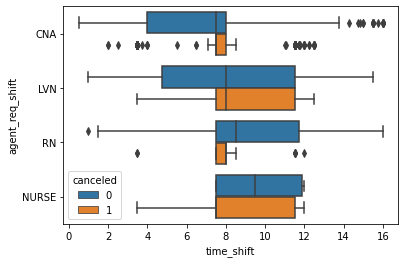

In [35]:
# charge_shift, time_shift, totalComp_shift need to be centered & scaled
sns.boxplot(data=df_feat, x='time_shift', y='agent_req_shift', hue='canceled');

While there are outliers, looking across healthcare worker types none of the very short and very long shift length are inherently implausible. It may be worth investigating whether very short shifts are booked by the same worker adjacent to a longer shift. 

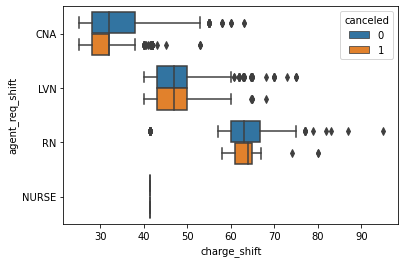

In [36]:
sns.boxplot(data=df_feat, x='charge_shift', y='agent_req_shift', hue='canceled');

Hourly charges for the three main categories of workers all have outliers, but this may have explanations such as special training or to balance short shift length. Latter may be worth investigating.

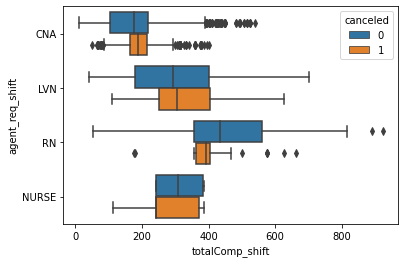

In [37]:
sns.boxplot(data=df_feat, x='totalComp_shift', y='agent_req_shift', hue='canceled');

None of the outliers can be identified as obvious 'mistakes'. However, their presence indicates use of Robust scaling.

### Set up preprocessing: scale and one-hot encode

In [38]:
# define factory method for scaler (note that scaler needs to be derived from training set only, then applied to both train and test data)
def make_scaler():
    return RobustScaler()

In [39]:
# setup a preprocessor to scale numerical features and one-hot encode categorical features(later to be included in pipeline)

# note: facility_id has a large number of categories -> explicitly include so the training set will not miss any (actually best to do that for all categorical variables with high cardinality, e.g., add hourofday, dayofweek)
facility = 'facility_id'
facility_categories = df_feat.facility_id.unique() # DEBUG
hour = 'hourOfDay_shift' 
# one-hot encoder expects numeric categories to be sorted
hour_categories = sorted(df_feat.hourOfDay_shift.unique())
remain_cat_features = [i for i in categorical_features if i not in [facility, hour]]

# TODO: use drop='if_binary' or drop='first' ?
preprocessor = ColumnTransformer(
    transformers=[
        ('scale_numerical', make_scaler(), numerical_features),
        ('onehot_facility', OneHotEncoder(categories = [facility_categories]), [facility]), # DEBUG 
        ('onehot_hour', OneHotEncoder(categories = [hour_categories]), [hour]),
        ('onehot_categorical', OneHotEncoder(), remain_cat_features)
    ],
    remainder='passthrough'
)

### Determine the Test / Train Split

In [40]:
# check for class imbalance
df_feat.canceled.value_counts()

canceled
0    7998
1    1316
Name: count, dtype: int64

In [41]:
# About 1:6 ratio of positive class (canceled) to negative class (booked)
# setup class weights for later use
class_weights = {0: 1, 1: 6}

Imbalanced classes may benefit from stratification (and/or from suffling, since it was sorted according to created_at during munging/EDA).

In [42]:
# split data into train / test sets: shuffles by default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

In [43]:
# define factory method for train/test split for cross validation
def make_cv_strategy():
    # default test_size is 0.1
    return StratifiedShuffleSplit(n_splits=5 , test_size=0.15)

### Grid Search and Scoring on Test Data

#### Models for comparison: Random Forest, Decision Tree, Logistic Regression, CatBoost, SVM

In [44]:
def make_rf_classifier(name='classifier'):
    param_grid = {
    name + '__n_estimators': [100, 200, 300],
    name + '__max_depth': [None, 5, 10]
    }
    classifier = RandomForestClassifier(class_weight='balanced')
    return (classifier, param_grid)

In [45]:
def make_tree_classifier(name='classifier'):
    param_grid = {
    name + '__criterion': ['gini'], # ['gini', 'entropy']
    name + '__max_depth': [i for i in range(3,9)],
    # name + '__min_samples_split': [25, 50, 100],
    # name + '__min_samples_leaf': [50, 75, 100, 150, 250, 500],
    # there are just over 100 featuers, given the cardinality of the categorical features (incl. 60 facilities)
    name + '__max_features': [0.3, 0.6, 0.7, 0.75, 0.8, 0.9],
    name + '__max_leaf_nodes': [15, 25, 30]
    # name + '__min_impurity_decrease': [0.0025, 0.005, 0.01]
    }
    classifier = DecisionTreeClassifier(class_weight='balanced')
    return (classifier, param_grid)

In [46]:
# TODO: parameterize to run with other penalty/solver combos 
def make_logreg_classifier(name='classifier'):
    param_grid = {
    name + '__penalty': ['l2', 'none'], # ['l1', 'l2', 'elasticnet', 'none'],
    name + '__C': [0.001, 0.01, 0.1, 1.0],
    # newton-cg only with penalty l2 or none 
    name + '__solver': ['newton-cg'], # 'lbfgs', 'sag', 'saga', 'liblinear'
    name + '__max_iter': [100, 150, 200],
    # name + '__class_weight': [None, 'balanced'],
    # name + '__multi_class': ['auto', 'ovr', 'multinomial'],
    # name + '__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
    }
    classifier = LogisticRegression(class_weight='balanced')
    return (classifier, param_grid)

In [64]:
# TODO: more params...
def make_catboost_classifier(name='classifier'):
    param_grid = {
    name + '__iterations': [100, 200, 300],
    name + '__learning_rate': [0.01, 0.05, 0.1],
    name + '__depth': [4, 6, 8],
    name + '__l2_leaf_reg': [1, 3, 5],
    }
    classifer = CatBoostClassifier(class_weights=class_weights, verbose=False)
    return (classifer, param_grid)

In [48]:
# TODO: more params...
def make_gradboost_classifier(name='classifer'):
    param_grid = {
    name + '__n_estimators': [100, 200, 300],
    name + '__learning_rate': [0.01, 0.05, 0.1],
    name + '__max_depth': [3, 4, 5],
    name + '__min_samples_split': [2, 5, 10],
    }
    classifer = GradientBoostingClassifier(class_weight='balanced')
    return (classifer, param_grid)

In [49]:
# TODO: more params
def make_SVM_classifier(name='classifer'):
    param_grid = {
    name + '__C': [0.1, 1], # [0.01, 0.1, 1, 10]
    name + '__kernel': ['linear', 'poly'], # ['linear', 'poly', 'rbf']
    name + '__gamma': ['auto'], # ['scale', 'auto'],
    }
    classifier = SVC(class_weight='balanced', probability=True)
    return (classifier, param_grid)

In [50]:
# could try this for logreg
# problem: fixed threshold leads to nan scores
def logreg_f1(y_true, y_pred):
    print('.')
    threshold = 0.45
    y_pred_fixed = (y_pred[:, 1] >= threshold).astype(int)
    return f1_score(y_true, y_pred_fixed)

# makes small difference (also: not sure about + vs. -, correct identification of positive class)
def logreg_f1_dyn_threshold(y_true, y_probabilities):
    threshold_percentage = 0.5  # Adjust this value as needed
    
    # temp code to see if custom scorer is used
    # display(f"Threshold: {threshold_percentage}")

    # Adjust the threshold based on the current fold's predictions
    threshold = np.mean(y_probabilities) + threshold_percentage * np.std(y_probabilities)

    # Calculate the binary predictions based on the adjusted threshold
    y_pred = (y_probabilities >= threshold).astype(int)

    # Calculate the F1-score with the adjusted threshold
    return f1_score(y_true, y_pred)

# problem: leads to f1 nan, possibly because some folds have no true positives
def logreg_f1_class_weights_auto(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary', pos_label=1, sample_weight='balanced')

# significantly improves f1 score - however, weighted scoring should not be 
# used in conjunction with weighted model
def logreg_f1_class_weights_fix(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary', pos_label=1, sample_weight=[class_weights[label] for label in y_true])


#### Grid Search

In [57]:
def gridsearch(model_name, classifier, scorer=make_scorer(f1_score, pos_label=1)):
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        (model_name, classifier[0])
    ])
    gs_cv = GridSearchCV(pipe, classifier[1], cv=make_cv_strategy(), scoring=scorer) # 'f1' 'accuracy'
    gs_cv.fit(X_train,y_train)
    print("Best Train Score:" + str(gs_cv.best_score_))
    print("Method:", gs_cv.scoring)
    print("Best Train Parameters: " + str(gs_cv.best_params_))
    return gs_cv

#### Scoring on Test Data

In [52]:
def model_eval(gs_cv):
    model = gs_cv.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Test Accuracy Score:", accuracy)
    print("Test F1 Score:", f1)

#### Running the Models

##### Decision Tree

In [58]:
# grid search w. cross validation
model_name = 'classifier'
classifier  = make_tree_classifier(model_name)
gs_cv  = gridsearch(model_name, classifier)
model_eval(gs_cv)

Best Train Score:0.3772339681952276
Method: make_scorer(f1_score, pos_label=1)
Best Train Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 0.8, 'classifier__max_leaf_nodes': 15}
Test Accuracy Score: 0.5748792270531401
Test F1 Score: 0.3612903225806452


Visualize the Decision Tree

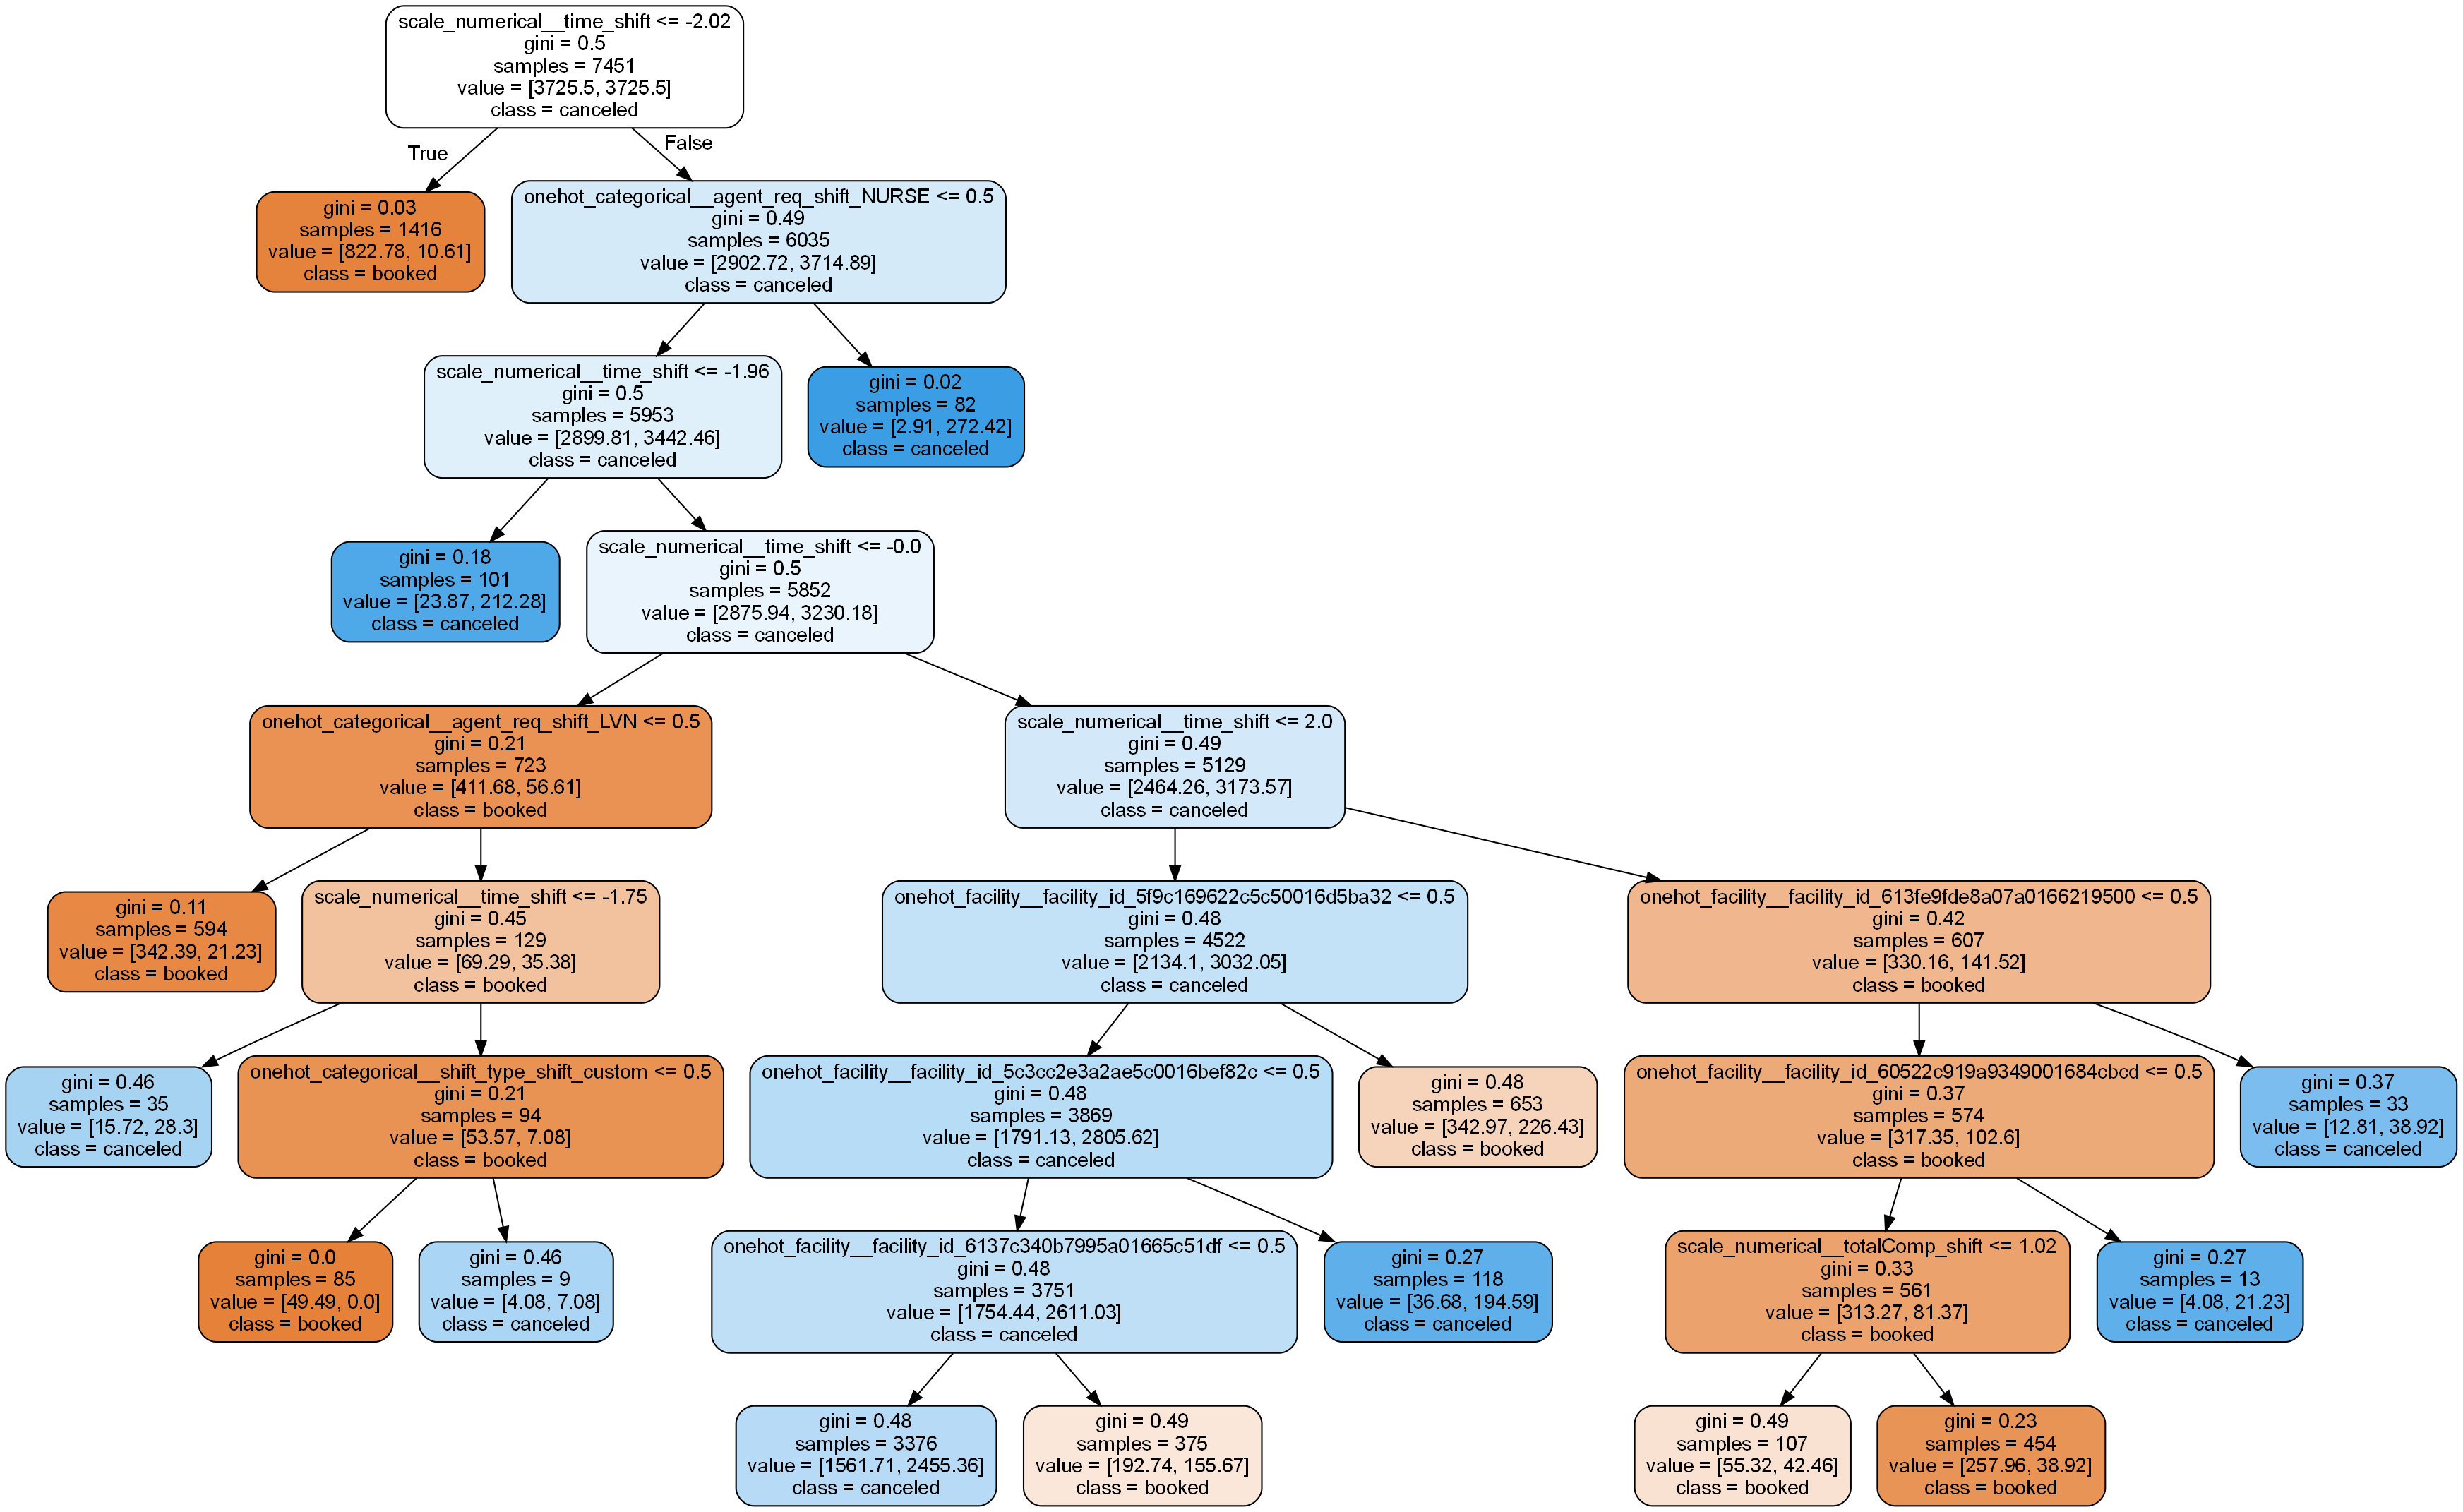

In [59]:
# retrieve the feature names generated by the column transformer (input to model)
best_pipeline = gs_cv.best_estimator_
column_transformer = best_pipeline.named_steps['preprocessor']
feature_names = column_transformer.get_feature_names_out()

# generate a tree representation into file
model = gs_cv.best_estimator_.named_steps.get(model_name)
class_dict = {0:'booked', 1:'canceled'}
export_graphviz(model, out_file='tree.dot', 
                feature_names = feature_names,
                 # note on order: checked that it's same as unique()
                class_names = [class_dict.get(i) for i in model.classes_],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# convert it to image
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=150'])

# display in notebook
from IPython.display import Image
Image(filename = 'tree.png')

Problems:
* remaining impurities seem high

Some things to sanity check:
* double check weather indicator: is time window of canceled shifts consistent with weather date range? (done)

Some things to try: 
* save current state , then re-do with time window of canceled/booked shifts the same (done)

Next:
* fix problem with facility one-hot encoding (done)
* try other models (Logistic Regression, RandomForest) (done)
    

##### Random Forest

In [61]:
# Random Forest grid search w. cross validation
model_name = 'classifier'
classifier  = make_rf_classifier(model_name)
gs_cv = gridsearch(model_name, classifier)
model_eval(gs_cv)

Best Train Score:0.40598208794333646
Method: make_scorer(f1_score, pos_label=1)
Best Train Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Test Accuracy Score: 0.667740203972088
Test F1 Score: 0.4042348411934552


##### Logistic Regression

In [62]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
model_name = 'classifier'
classifier = make_logreg_classifier(model_name)
# Create the scorer using the custom scoring function
# custom_scorer = make_scorer(logreg_f1_dyn_threshold, needs_proba=True) # pos_label=1)
# custom_scorer = make_scorer(logreg_f1_class_weights_fix) # result: 0.64
gs_cv = gridsearch(model_name, classifier) # , scorer=custom_scorer
model_eval(gs_cv)

Best Train Score:0.3382819963235991
Method: make_scorer(f1_score, pos_label=1)
Best Train Parameters: {'classifier__C': 1.0, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
Test Accuracy Score: 0.6451959205582394
Test F1 Score: 0.3525954946131244


##### Gradient Boost (CatBoost)

In [65]:
# TODO: leave out one-hot encoding (CatBoost handles it automatically)
model_name = 'classifier'
classifier = make_catboost_classifier(model_name)
gs_cv = gridsearch(model_name, classifier)
model_eval(gs_cv)

Best Train Score:0.46119179350304285
Method: make_scorer(f1_score, pos_label=1)
Best Train Parameters: {'classifier__depth': 8, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.1}
Test Accuracy Score: 0.7455716586151369
Test F1 Score: 0.4539170506912442


##### SVM

In [ ]:
model_name = 'classifier'
classifier = make_SVM_classifier(model_name)
gs_cv = gridsearch(model_name, classifier)
model_eval(gs_cv)